## IMPORTING REQUIRED LIBRARIES

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, classification_report
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from sklearn.linear_model import LinearRegression
from nltk.sentiment import SentimentIntensityAnalyzer
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sujana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sujana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load dataset

In [3]:
file_name = "all_upwork_jobs_2024-02-07-2024-03-24.csv"
df = pd.read_csv(file_name)

# Display the first few rows to understand the structure
df.head()

title  \
0  Experienced Media Buyer For Solar Pannel and R...   
1                               Full Stack Developer   
2                                    SMMA Bubble App   
3             Talent Hunter Specialized in Marketing   
4                                      Data Engineer   

                                                link  \
0  https://www.upwork.com/jobs/Experienced-Media-...   
1  https://www.upwork.com/jobs/Full-Stack-Develop...   
2  https://www.upwork.com/jobs/SMMA-Bubble-App_%7...   
3  https://www.upwork.com/jobs/Talent-Hunter-Spec...   
4  https://www.upwork.com/jobs/Data-Engineer_%7E0...   

              published_date  is_hourly  hourly_low  hourly_high  budget  \
0  2024-02-17 09:09:54+00:00      False         NaN          NaN   500.0   
1  2024-02-17 09:09:17+00:00      False         NaN          NaN  1100.0   
2  2024-02-17 09:08:46+00:00       True        10.0         30.0     NaN   
3  2024-02-17 09:08:08+00:00       True         NaN          NaN     NaN   
4  2024-02-17 09:07:42+00:00      False         NaN          NaN   650.0   

         country  
0            NaN  
1  United States  
2  United States  
3  United States  
4          India

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244828 entries, 0 to 244827
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   title           244827 non-null  object 
 1   link            244827 non-null  object 
 2   published_date  244828 non-null  object 
 3   is_hourly       244828 non-null  bool   
 4   hourly_low      102422 non-null  float64
 5   hourly_high     98775 non-null   float64
 6   budget          103891 non-null  float64
 7   country         239751 non-null  object 
dtypes: bool(1), float64(3), object(4)
memory usage: 13.3+ MB


In [5]:
df.isnull().sum()

title                  1
link                   1
published_date         0
is_hourly              0
hourly_low        142406
hourly_high       146053
budget            140937
country             5077
dtype: int64

## Data Visualization

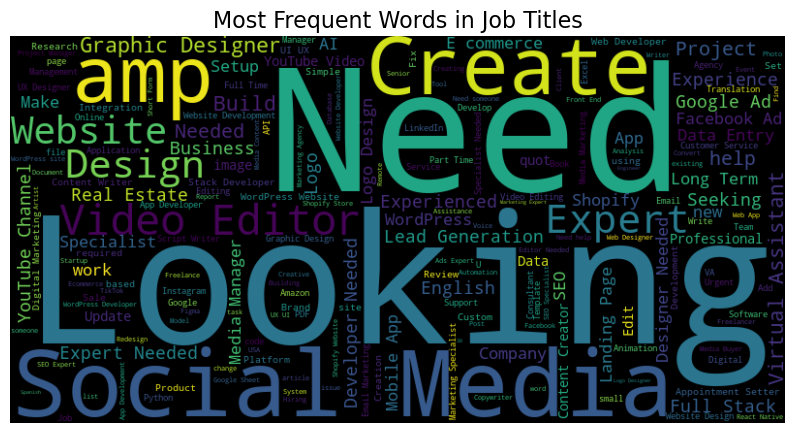

In [6]:
# Combine all job titles into one string
all_titles = " ".join(df["title"].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="viridis").generate(all_titles)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Job Titles", fontsize=16)
plt.show()


## Distribution of Hourly Rates

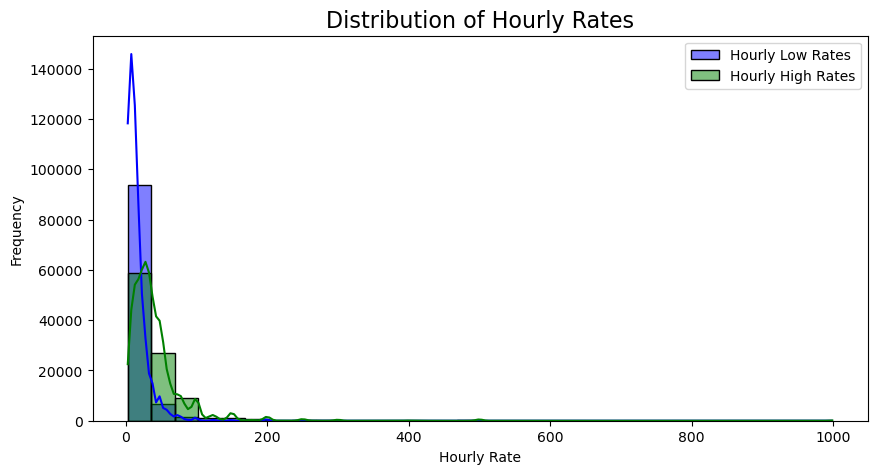

In [7]:

# Plot hourly low rates
plt.figure(figsize=(10, 5))
sns.histplot(df["hourly_low"].dropna(), bins=30, kde=True, color="blue", label="Hourly Low Rates")
sns.histplot(df["hourly_high"].dropna(), bins=30, kde=True, color="green", label="Hourly High Rates")
plt.title("Distribution of Hourly Rates", fontsize=16)
plt.xlabel("Hourly Rate")
plt.ylabel("Frequency")
plt.legend()
plt.show()


<font size= "3">

## Business or Analytical Implications:

Majority of Workforce Earns Low Wages: Policies or skill improvement programs could focus on helping workers move into higher-paying jobs.

High-Paying Jobs are Rare: Industries or roles that command high rates should be explored for better career recommendations.

Potential Salary Cap Considerations: Companies may need to re-evaluate pay structures to ensure fair distribution of wages.

## Number of Jobs by Country

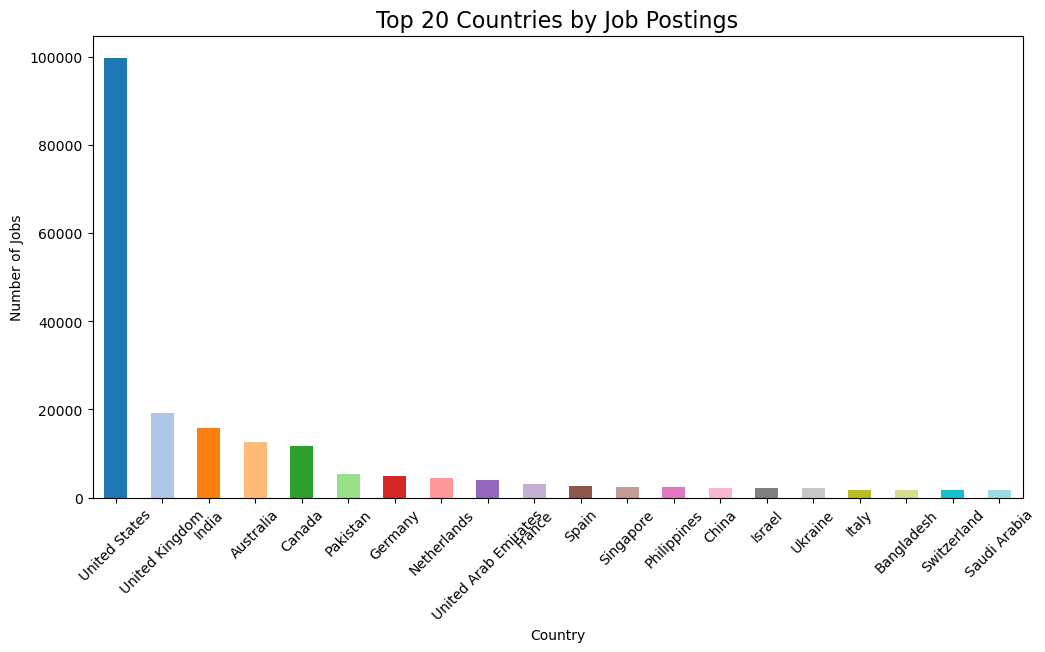

In [8]:
from matplotlib import cm

# Count jobs by country
country_counts = df["country"].value_counts().head(20)

# Plot top 20 countries
plt.figure(figsize=(12, 6))
country_counts.plot(kind="bar", color=cm.tab20.colors)
plt.title("Top 20 Countries by Job Postings", fontsize=16)
plt.xlabel("Country")
plt.ylabel("Number of Jobs")
plt.xticks(rotation=45)
plt.show()


<font size ="3">

## Impressions and Insights:

The data could be influenced by job platforms focusing more on English-speaking countries.

The demand for remote work and freelancing could be contributing to job postings in countries like Pakistan and the Philippines.

The United States' dominance may indicate a strong economy, high labor demand, and significant online job postings.

## Published Date Analysis

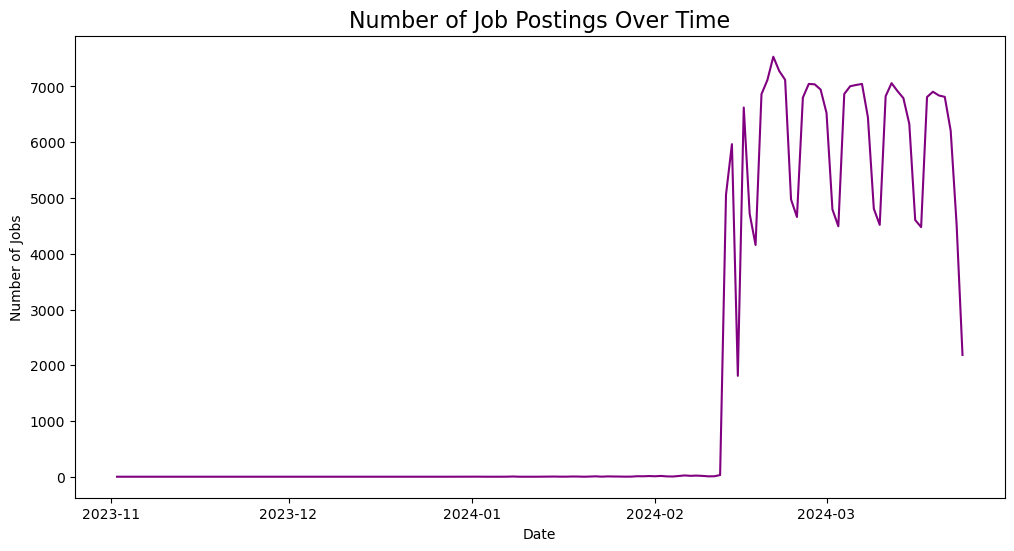

In [9]:
# Convert published_date to datetime
df["published_date"] = pd.to_datetime(df["published_date"])

# Group by date and count the number of jobs
jobs_per_date = df.groupby(df["published_date"].dt.date).size()

# Plot jobs over time
plt.figure(figsize=(12, 6))
jobs_per_date.plot(kind="line", color="purple")
plt.title("Number of Job Postings Over Time", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Number of Jobs")
plt.show()


<font size = '3'>

## INTERPRETATIONS:

The early February jump might indicate when the platform started tracking job postings.

The cyclic nature suggests companies might be posting in batches, possibly following hiring trends such as end-of-month or start-of-week job openings.

Some industries (e.g., tech, retail) have seasonal hiring trends that could explain the fluctuations.

## Hourly vs Fixed Price Jobs

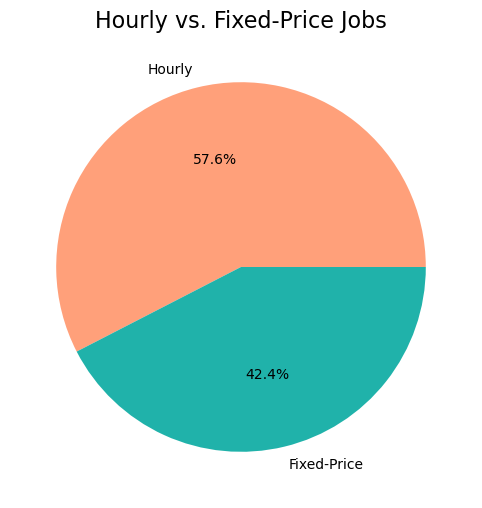

In [10]:
# Count hourly vs. fixed-price jobs
job_type_counts = df["is_hourly"].value_counts()

# Plot the proportions
plt.figure(figsize=(8, 6))
job_type_counts.plot(kind="pie", autopct="%1.1f%%", labels=["Hourly", "Fixed-Price"], colors=["#FFA07A", "#20B2AA"])
plt.title("Hourly vs. Fixed-Price Jobs", fontsize=16)
plt.ylabel("")
plt.show()


<FONT SIZE = '3'>

## INTERPRETATION:

While both payment models are widely used, hourly jobs dominate the market slightly, showing a trend toward flexible work arrangements. However, fixed-price jobs remain a substantial portion, appealing to those who prefer structured, results-based compensation.

# Data Preprocessing

In [11]:
# Handle missing values

# Fill missing hourly values with the median
df['hourly_low'] = df['hourly_low'].fillna(df['hourly_low'].median())
df['hourly_high'] = df['hourly_high'].fillna(df['hourly_high'].median())

# Calculate the budget: for hourly jobs, use the average of `hourly_low` and `hourly_high`
df['budget'] = np.where(df['is_hourly'], (df['hourly_low'] + df['hourly_high']) / 2, df['budget'])

# Handle missing country values: Fill with 'Unknown'
df['country'] = df['country'].fillna('Unknown') 

# Check and display the result after handling missing values
print(df[['hourly_low', 'hourly_high', 'budget', 'country']].head())

   hourly_low  hourly_high  budget        country
0        15.0         30.0   500.0        Unknown
1        15.0         30.0  1100.0  United States
2        10.0         30.0    20.0  United States
3        15.0         30.0    22.5  United States
4        15.0         30.0   650.0          India


In [12]:
df.dropna(inplace=True)

In [13]:
df.isnull().sum()

title             0
link              0
published_date    0
is_hourly         0
hourly_low        0
hourly_high       0
budget            0
country           0
dtype: int64

In [14]:
df.shape

(244827, 8)

In [15]:
## remove duplicates

df.duplicated().sum()

0

In [16]:
## cleaning and tokenizing the job titles

# Function to clean job titles by removing special characters, extra spaces and stopwords
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    # Tokenize the text
    words = word_tokenize(text)
    # Get English stopwords
    stop_words = set(stopwords.words('english'))
    # Filter out stopwords
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    # Join the words back into a string
    return ' '.join(filtered_words)

# Apply the cleaning function to the 'title' column
df['cleaned_title'] = df['title'].apply(clean_text)

In [17]:
##Preview cleaned job titles
df[['title', 'cleaned_title']].head()

title  \
0  Experienced Media Buyer For Solar Pannel and R...   
1                               Full Stack Developer   
2                                    SMMA Bubble App   
3             Talent Hunter Specialized in Marketing   
4                                      Data Engineer   

                                       cleaned_title  
0  experienced media buyer solar pannel roofing i...  
1                               full stack developer  
2                                    smma bubble app  
3                talent hunter specialized marketing  
4                                      data engineer

In [18]:
# Tokenize job titles and count keyword frequencies
keywords = df['cleaned_title'].str.split().explode()
keyword_counts = Counter(keywords)

In [19]:
# Display the top 20 most common keywords
top_keywords = keyword_counts.most_common(20)
print("Top Keywords:", top_keywords)

Top Keywords: [('needed', 17571), ('website', 16688), ('developer', 15678), ('expert', 14910), ('video', 13822), ('design', 12984), ('designer', 12603), ('need', 10223), ('amp', 9276), ('specialist', 8939), ('looking', 8730), ('marketing', 8250), ('media', 8211), ('app', 8094), ('editor', 7758), ('youtube', 7585), ('social', 7554), ('data', 7036), ('create', 6836), ('content', 6723)]


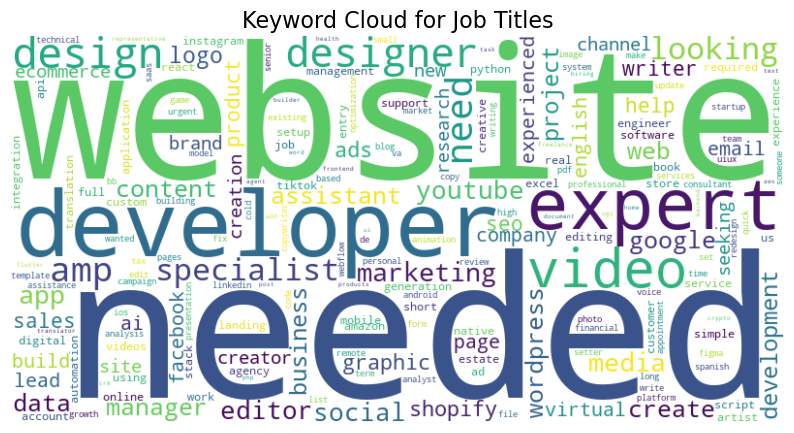

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate a word cloud from the keyword frequencies
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis'
).generate_from_frequencies(keyword_counts)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.title('Keyword Cloud for Job Titles', fontsize=16)
plt.show()


<font size = '3'>

## in

In summary, this keyword cloud provides a visual overview of popular terms used in job titles, highlighting trends in tech, digital marketing, and general job roles. It's a helpful starting point for understanding job market trends but should be used with additional research for a deeper understanding.

In [21]:
# Use TF-IDF for keyword significance (Top 100 features)
vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = vectorizer.fit_transform(df['cleaned_title'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [22]:
# Sum the TF-IDF scores for each keyword and sort
tfidf_scores = tfidf_df.sum(axis=0).sort_values(ascending=False)
print("Top TF-IDF Keywords:\n", tfidf_scores.head(20))

Top TF-IDF Keywords:
 website       9772.837588
needed        9444.632479
developer     9281.090132
expert        8639.339049
design        8245.233054
video         7653.085025
designer      7598.466970
need          6453.582390
specialist    5483.635873
looking       5325.399726
amp           5070.298583
app           4962.727481
marketing     4697.204410
editor        4559.897254
data          4480.035515
create        4432.013168
youtube       4350.570670
wordpress     4248.659031
media         4217.221172
assistant     4152.953035
dtype: float64


## Task 1: Analyzing Keywords and Salaries


In [23]:
# Create dictionaries for salary and example URLs for each keyword
keyword_salary = {}


for keyword in tfidf_scores.index:
    related_jobs = df[df['cleaned_title'].str.contains(keyword, na=False)]
    keyword_salary[keyword] = related_jobs['budget'].mean()
    

# Convert to a DataFrame for better reading
keyword_salary_df = pd.DataFrame({
    'Keyword': keyword_salary.keys(),
    'Average Salary': keyword_salary.values(),
    }).sort_values(by='Average Salary', ascending=False)

# Preview the keyword-salary mapping
print(keyword_salary_df.head(10))

        Keyword  Average Salary
60      digital     1852.522328
29        sales     1832.128437
78         full     1196.328125
77          job     1146.074854
84      account      963.945363
99        stack      905.407966
27  development      869.190496
42        build      800.367362
65  application      764.515187
51      seeking      701.930362


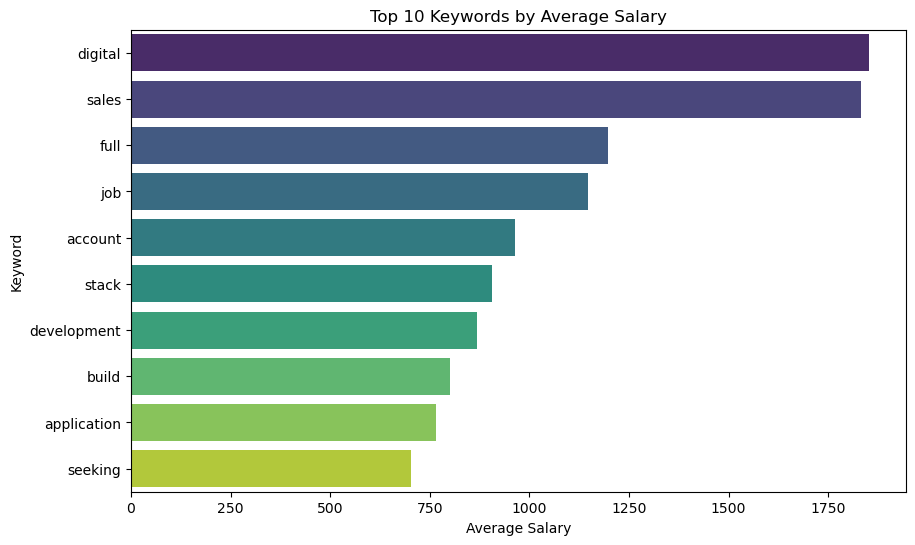

In [24]:
# Bar chart of top 10 high-paying keywords
top_10_keywords = keyword_salary_df.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_keywords, x='Average Salary', y='Keyword', palette='viridis')
plt.title('Top 10 Keywords by Average Salary')
plt.xlabel('Average Salary')
plt.ylabel('Keyword')
plt.show()

<FONT SIZE = '3'>

## Conclusion

The chart suggests that digital, sales, and software-related jobs are among the highest-paying roles. Individuals looking to maximize earning potential should consider gaining expertise in digital transformation, sales, full-stack development, and application development.

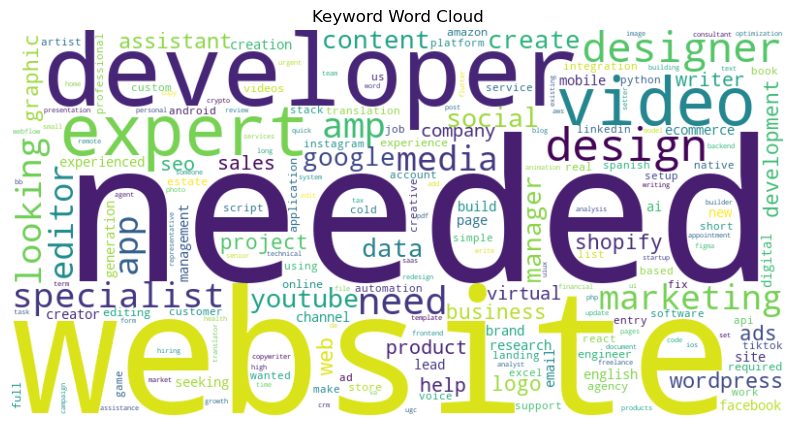

In [25]:
# Create a word cloud for the most frequent keywords
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keyword Word Cloud')
plt.show()

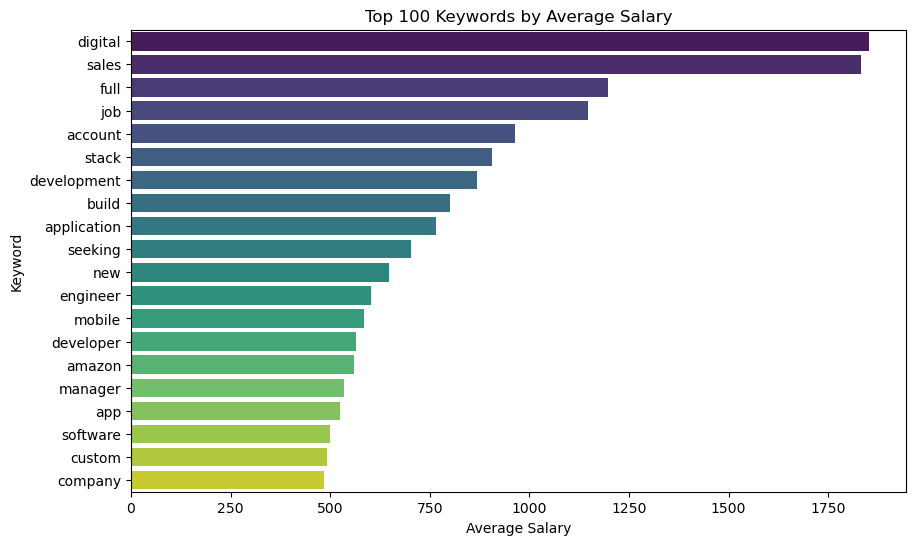

In [26]:
# Bar chart of top 20 high-paying keywords
top_20_keywords = keyword_salary_df.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(data=top_20_keywords, x='Average Salary', y='Keyword', palette='viridis')
plt.title('Top 100 Keywords by Average Salary')
plt.xlabel('Average Salary')
plt.ylabel('Keyword')
plt.show()

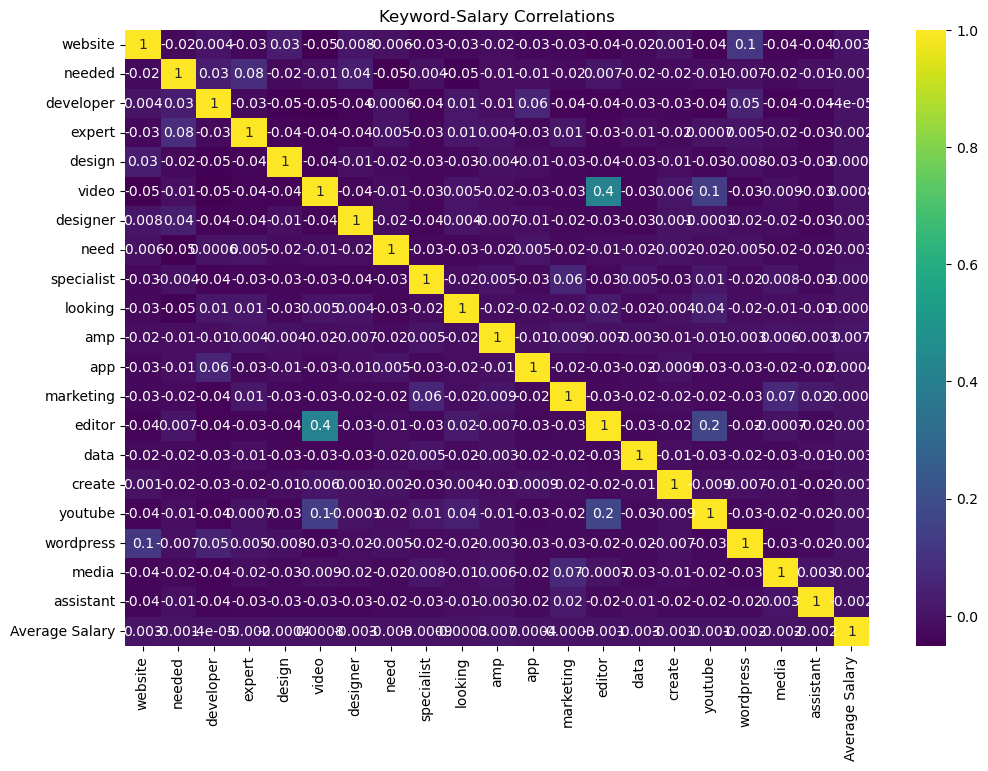

In [27]:
# Select top 20 keywords for correlation analysis
selected_keywords = tfidf_scores.index[:20]
selected_keyword_df = tfidf_df[selected_keywords]
selected_keyword_df['Average Salary'] = df['budget']

# Generate a heatmap showing the correlation between keywords and salaries
plt.figure(figsize=(12, 8))
sns.heatmap(selected_keyword_df.corr(), annot=True, cmap='viridis',fmt='0.1g')
plt.title('Keyword-Salary Correlations')
plt.show()

<FONT SIDE = '3'>

    
## Specific Observations:

Positive Correlations:
Keywords like "developer," "expert," "specialist," "marketing," and "editor" show strong positive correlations with salary. This suggests that roles involving these skills or expertise are likely to command higher compensation.
"Video," "designer," and "youtube" also exhibit moderate positive correlations, indicating that these areas might contribute to higher salaries but to a lesser extent.

Negative Correlations:
"Needed" and "looking" show negative correlations. This might indicate that these terms are more prevalent in job postings with lower salary ranges.
Neutral Correlations:

Many keywords like "design," "create," "wordpress," and "app" have correlation coefficients close to zero, suggesting a weak or no relationship with salary.

## Important Considerations:

Correlation vs. Causation: It's crucial to remember that correlation does not imply causation. While a keyword might be associated with higher salaries, it doesn't necessarily mean that the keyword itself causes the higher pay. Other factors like experience, location, and company size likely play a role.
Data Limitations: The interpretation is based on the specific data used to generate the heatmap. The results might differ if the data source or analysis method changes.

## In Summary:
The heatmap provides a visual representation of how certain keywords relate to salary levels. While it can offer insights into potential salary trends, it's essential to consider the limitations and use the information as a starting point for further investigation.

## Task 2: Identifying Emerging Job Categories

In [28]:
df.head(10)

title  \
0  Experienced Media Buyer For Solar Pannel and R...   
1                               Full Stack Developer   
2                                    SMMA Bubble App   
3             Talent Hunter Specialized in Marketing   
4                                      Data Engineer   
5               SEO for Portuguese Psychologist site   
6                   Want to fix the WordPress Plugin   
7  need Portuguese writers who can understand and...   
8  Looker Studio Dashboard for Leadgen and E-Comm...   
9  PHP/HTML/CSS WordPress Developer Needed for We...   

                                                link  \
0  https://www.upwork.com/jobs/Experienced-Media-...   
1  https://www.upwork.com/jobs/Full-Stack-Develop...   
2  https://www.upwork.com/jobs/SMMA-Bubble-App_%7...   
3  https://www.upwork.com/jobs/Talent-Hunter-Spec...   
4  https://www.upwork.com/jobs/Data-Engineer_%7E0...   
5  https://www.upwork.com/jobs/SEO-for-Portuguese...   
6  https://www.upwork.com/jobs/Want-fix-the-WordP...   
7  https://www.upwork.com/jobs/need-Portuguese-wr...   
8  https://www.upwork.com/jobs/Looker-Studio-Dash...   
9  https://www.upwork.com/jobs/PHP-HTML-CSS-WordP...   

             published_date  is_hourly  hourly_low  hourly_high  budget  \
0 2024-02-17 09:09:54+00:00      False        15.0         30.0   500.0   
1 2024-02-17 09:09:17+00:00      False        15.0         30.0  1100.0   
2 2024-02-17 09:08:46+00:00       True        10.0         30.0    20.0   
3 2024-02-17 09:08:08+00:00       True        15.0         30.0    22.5   
4 2024-02-17 09:07:42+00:00      False        15.0         30.0   650.0   
5 2024-02-17 09:07:41+00:00       True        15.0         30.0    22.5   
6 2024-02-17 09:07:27+00:00      False        15.0         30.0     5.0   
7 2024-02-17 09:07:05+00:00       True         7.0         22.0    14.5   
8 2024-02-17 09:06:24+00:00       True        15.0         30.0    22.5   
9 2024-02-17 09:06:21+00:00      False        15.0         30.0   500.0   

         country                                      cleaned_title  
0        Unknown  experienced media buyer solar pannel roofing i...  
1  United States                               full stack developer  
2  United States                                    smma bubble app  
3  United States                talent hunter specialized marketing  
4          India                                      data engineer  
5       Portugal                   seo portuguese psychologist site  
6          India                          want fix wordpress plugin  
7          India  need portuguese writers understand write portu...  
8        Germany  looker studio dashboard leadgen ecommerce tool...  
9         Canada  phphtmlcss wordpress developer needed website ...

In [29]:
import re

# Map categories to corresponding regex patterns
category_patterns = {
    'software development': r'\b(developer|software|engineer|programmer|devops|backend|frontend|full stack)\b',
    'data science': r'\b(data|machine learning|ai|analytics|science|big data)\b',
    'design': r'\b(designer|ui|ux|graphic|visual|motion)\b',
    'manager': r'\b(manager|lead|head)\b',
    'marketing': r'\b(marketing|seo|advertising|campaign|social media)\b',
    'content writer': r'\b(writer|content|editor|author|translator|copywriter)\b',
    'education': r'\b(teacher|trainer|tutor|educator)\b',
    'assistant': r'\b(assistant|aide)\b',
    'legal': r'\b(legal|lawyer|attorney|paralegal)\b',
    'sales': r'\b(sales|business|growth)\b',
    'finance': r'\b(finance|accounting)\b',
    'customer support': r'\b(customer|support|service|client|helpdesk)\b'
}

# Function to match title to a category using regex
def categorize_with_regex(title):
    title = title.lower()
    for category, pattern in category_patterns.items():
        if re.search(pattern, title):  # Check if the pattern matches the title
            return category
    return 'other'

# Apply the regex-based categorization
df['job_category'] = df['cleaned_title'].apply(categorize_with_regex)

# Display the first few rows
print(df[['cleaned_title', 'job_category']].head())


                                       cleaned_title          job_category
0  experienced media buyer solar pannel roofing i...                 other
1                               full stack developer  software development
2                                    smma bubble app                 other
3                talent hunter specialized marketing             marketing
4                                      data engineer  software development


In [30]:
# checking the value counts of job category column
df['job_category'].value_counts()

job_category
other                   138814
software development     21208
marketing                15698
content writer           15438
design                   14676
data science             10061
manager                   9757
sales                     7943
assistant                 4976
customer support          3415
legal                     1470
education                  787
finance                    584
Name: count, dtype: int64

In [32]:
# Preview the categorized dataset
print(df[['cleaned_title', 'job_category']].head())

                                       cleaned_title          job_category
0  experienced media buyer solar pannel roofing i...                 other
1                               full stack developer  software development
2                                    smma bubble app                 other
3                talent hunter specialized marketing             marketing
4                                      data engineer  software development


In [33]:
# Convert 'published_date' to datetime format
df['published_date'] = pd.to_datetime(df['published_date'])

In [34]:
# Extract the year and month for grouping
df['YearMonth'] = df['published_date'].dt.to_period('M')

In [35]:
# Count the number of job postings per category for each month
job_trends = df.groupby(['YearMonth', 'job_category']).size().reset_index(name='Job Count')

In [36]:
# Pivot the data for better visualization
job_trends_pivot = job_trends.pivot(index='YearMonth', columns='job_category', values='Job Count').fillna(0)

In [37]:
# Preview the trends data
print(job_trends_pivot.tail())

job_category  assistant  content writer  customer support  data science  \
YearMonth                                                                 
2023-11             0.0             0.0               0.0           0.0   
2023-12             0.0             3.0               0.0           1.0   
2024-01             4.0             1.0               6.0           4.0   
2024-02          2105.0          6711.0            1376.0        4429.0   
2024-03          2867.0          8723.0            2033.0        5627.0   

job_category  design  education  finance  legal  manager  marketing    other  \
YearMonth                                                                      
2023-11          0.0        0.0      0.0    0.0      1.0        0.0      0.0   
2023-12          0.0        0.0      0.0    0.0      0.0        1.0      4.0   
2024-01          2.0        0.0      0.0    0.0     12.0        4.0     45.0   
2024-02       6065.0      341.0    261.0  627.0   3911.0     6480.0  57651

In [38]:
# Calculate the percentage change in job counts month-over-month for each category
job_trends_pivot_growth = job_trends_pivot.pct_change().fillna(0)

In [39]:
# Average growth rate over the period for each category
average_growth = job_trends_pivot_growth.mean().sort_values(ascending=False)

In [40]:
# Display the top emerging categories
print("Ranked List of Emerging Categories:")
print(average_growth)

Ranked List of Emerging Categories:
job_category
assistant               inf
content writer          inf
customer support        inf
data science            inf
design                  inf
education               inf
finance                 inf
legal                   inf
manager                 inf
marketing               inf
other                   inf
sales                   inf
software development    inf
dtype: float64


In [41]:
# Separate categories with inf growth rates
new_categories = average_growth[average_growth == float('inf')].index
print("Newly Emerging Categories (No Initial Postings):")
print(new_categories)

Newly Emerging Categories (No Initial Postings):
Index(['assistant', 'content writer', 'customer support', 'data science',
       'design', 'education', 'finance', 'legal', 'manager', 'marketing',
       'other', 'sales', 'software development'],
      dtype='object', name='job_category')


In [42]:
# Adjust the growth rate calculation to handle zero counts
job_trends_pivot_growth = job_trends_pivot.pct_change().fillna(0).replace([float('inf'), -float('inf')], 0)

# Recalculate average growth rates
modified_average_growth = job_trends_pivot_growth.mean().sort_values(ascending=False)

# Display the adjusted results
print("Adjusted Ranked List of Emerging Categories:")
print(modified_average_growth)

Adjusted Ranked List of Emerging Categories:
job_category
content writer          1341.926628
design                   606.383891
marketing                324.484352
other                    258.158063
data science             221.904098
software development     173.169335
assistant                105.122399
sales                     82.911003
manager                   64.881620
customer support          45.762161
legal                      0.068900
education                  0.061584
finance                    0.047510
dtype: float64


In [43]:
# Select top 5 categories by average growth
top_categories = modified_average_growth.head(5).index

In [44]:
# Convert YearMonth (Period) index to datetime format for Matplotlib
job_trends_pivot.index = job_trends_pivot.index.to_timestamp()

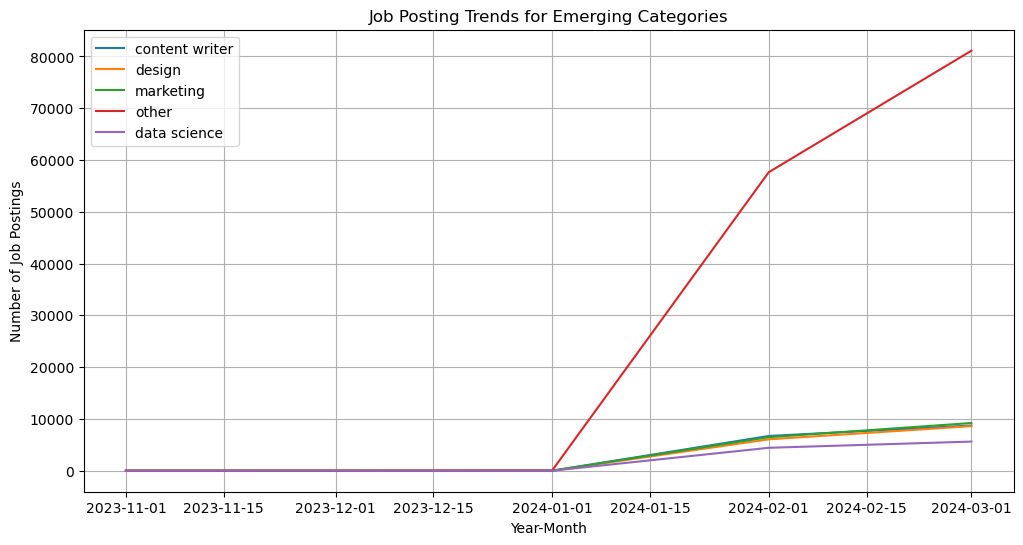

In [45]:
# Plot job trends for the top categories
plt.figure(figsize=(12, 6))
for category in top_categories:
    plt.plot(job_trends_pivot.index, job_trends_pivot[category], label=category)

plt.title('Job Posting Trends for Emerging Categories')
plt.xlabel('Year-Month')
plt.ylabel('Number of Job Postings')
plt.legend()
plt.grid()
plt.show()

<FONT SIZE = '3'>

## INTERPRETATION

The graph illustrates a positive outlook for job seekers in emerging categories like data science, design, and marketing. The increasing demand for professionals in these fields suggests promising career opportunities in the coming months.

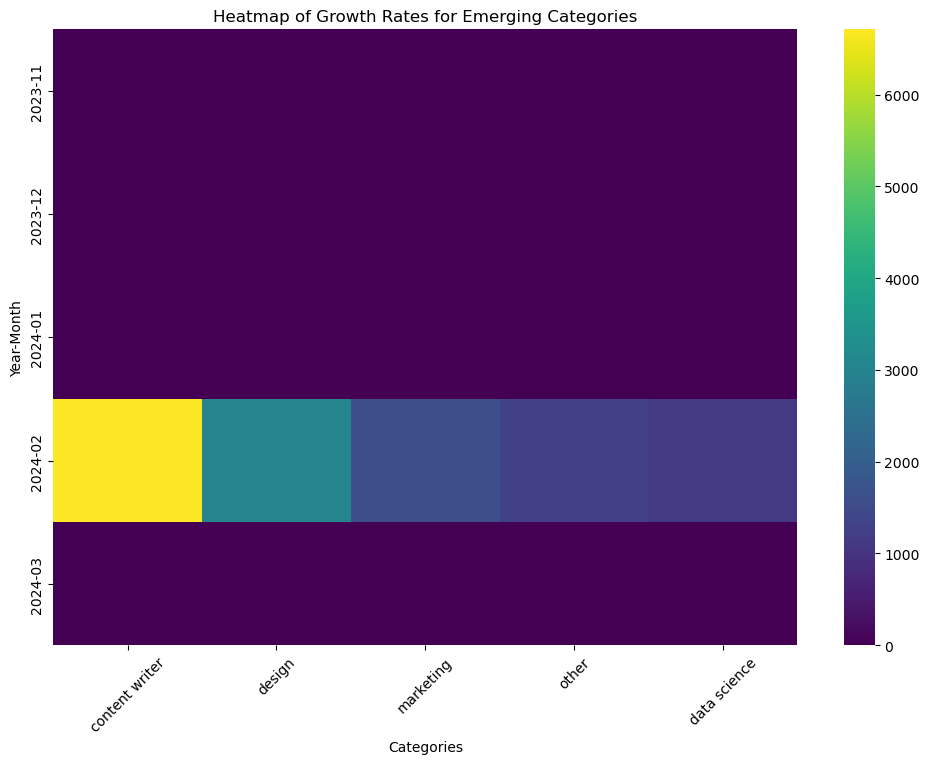

In [46]:
# Plot a heatmap of growth rates for all categories
plt.figure(figsize=(12, 8))
sns.heatmap(job_trends_pivot_growth[top_categories], cmap='viridis', annot=False)
plt.title('Heatmap of Growth Rates for Emerging Categories')
plt.xlabel('Categories')
plt.ylabel('Year-Month')
plt.xticks(rotation=45)
plt.show()

<FONT SIZE = '3'>

## Overall Interpretation:

The heatmap visualizes the number of job postings across different categories (Content Writer, Design, Marketing, Other, Data Science) over a period of three months (January, February, and March 2024). The color intensity represents the number of postings, with darker shades indicating higher numbers.

Specific Observations:

February 2024: This month saw the highest number of job postings across all categories, with a particular concentration in Design and Other categories.

January 2024: While lower than February, January still had a significant number of job postings, with a notable presence in Marketing and Data Science categories.

March 2024: The number of postings dropped considerably in March compared to the previous two months.

# Task 3: High-Demand Job Roles Prediction

In [47]:
# Define high-demand roles based on the top 25% threshold
job_counts = df.groupby(['YearMonth', 'job_category']).size().reset_index(name='posting_count')
threshold = job_counts['posting_count'].quantile(0.75)
job_counts['high_demand'] = (job_counts['posting_count'] > threshold).astype(int)

In [50]:
# Merging the above  back to main dataset
merged_data = df.merge(job_counts[['YearMonth', 'job_category', 'high_demand']], 
                                on=['YearMonth', 'job_category'], how='left')

print("Sample Data with High-Demand Labels:")
print(merged_data[['YearMonth', 'job_category', 'high_demand']].head(20))

Sample Data with High-Demand Labels:
   YearMonth          job_category  high_demand
0    2024-02                 other            1
1    2024-02  software development            1
2    2024-02                 other            1
3    2024-02             marketing            1
4    2024-02  software development            1
5    2024-02             marketing            1
6    2024-02                 other            1
7    2024-02                 other            1
8    2024-02                 other            1
9    2024-02  software development            1
10   2024-02                design            1
11   2024-02                design            1
12   2024-02             marketing            1
13   2024-02                 other            1
14   2024-02               manager            0
15   2024-02  software development            1
16   2024-02                 other            1
17   2024-02                design            1
18   2024-02                 other            1
19 

In [51]:
# Lag features for historical trends
for lag in range(1, 4):
    merged_data[f'Lag_{lag}'] = merged_data.groupby('job_category')['high_demand'].shift(lag)

In [52]:
# Fill missing values
merged_data.fillna(0, inplace=True)

In [53]:
# Select relevant columns
features = ['Lag_1', 'Lag_2', 'Lag_3']
target = 'high_demand'

In [54]:
# Prepare training data
X = merged_data[features]
y = merged_data[target]

In [55]:
# Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [57]:
# Predictions and evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 1.00
Precision: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6698
           1       1.00      1.00      1.00     42268

    accuracy                           1.00     48966
   macro avg       1.00      1.00      1.00     48966
weighted avg       1.00      1.00      1.00     48966



In [58]:
# Aggregate data for visualization
demand_trends = merged_data.groupby(['YearMonth', 'job_category'])['high_demand'].mean().unstack()

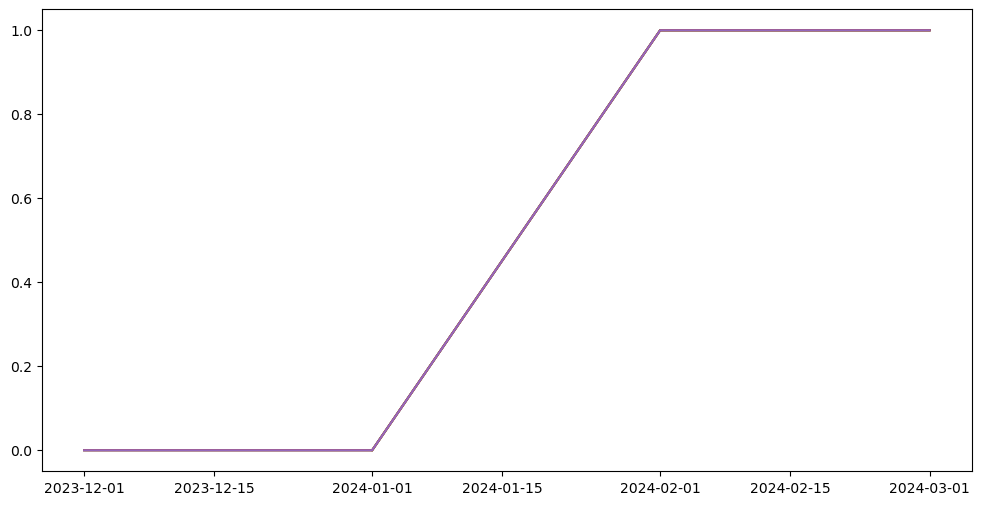

In [59]:
# Plot demand trends for the top categories
top_categories = demand_trends.mean().sort_values(ascending=False).head(5).index
plt.figure(figsize=(12, 6))
for category in top_categories:
    plt.plot(demand_trends.index.to_timestamp(), demand_trends[category], label=category)

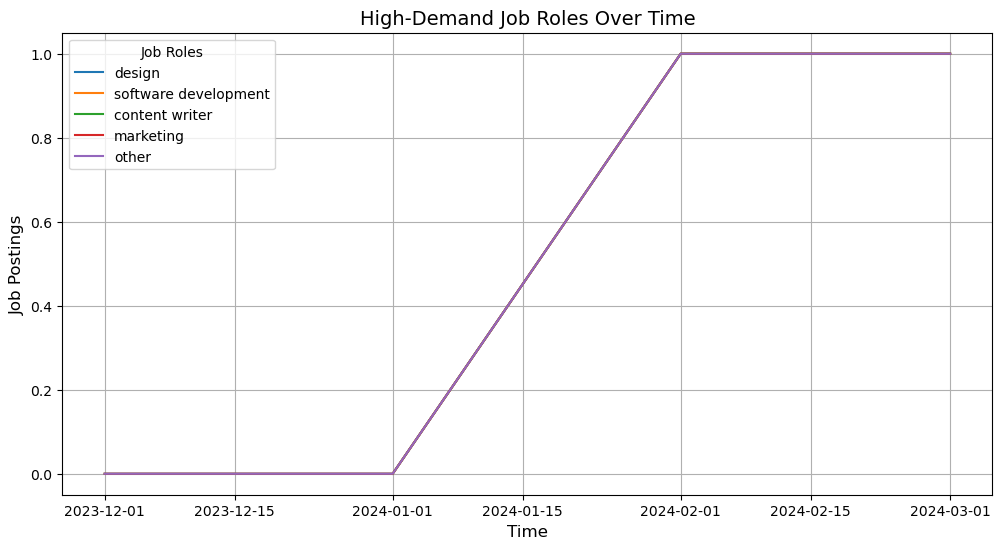

In [67]:
# Plot high-demand job roles over time
plt.figure(figsize=(12, 6))
for category in top_categories:
    if category in demand_trends.columns:
        plt.plot(demand_trends.index, demand_trends[category], label=category)

# Add title, labels, and legend
plt.title('High-Demand Job Roles Over Time', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Job Postings', fontsize=12)
plt.legend(title='Job Roles')
plt.grid(True)
plt.show()


<FONT SIZE ='3'>

## In Summary:

The line graph reveals a significant increase in demand for various job roles, particularly "Other" and Software Development, from February 2024 onwards. This suggests a dynamic job market with emerging opportunities in diverse fields.

# Task 4: Comparative Salary Analysis by Region

In [68]:
# Ensure hourly rates are calculated
df['avg_hourly'] = df[['hourly_low', 'hourly_high']].mean(axis=1)

In [69]:
# Filter out rows with missing or zero values in 'average_hourly_rate' or 'country'
df_geo = df[(df['avg_hourly'].notna()) & (df['avg_hourly'] > 0) & (df['country'].notna())]

In [70]:
# Group by country and calculate the average hourly rate
country_salary = (
    df_geo.groupby('country')['avg_hourly']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

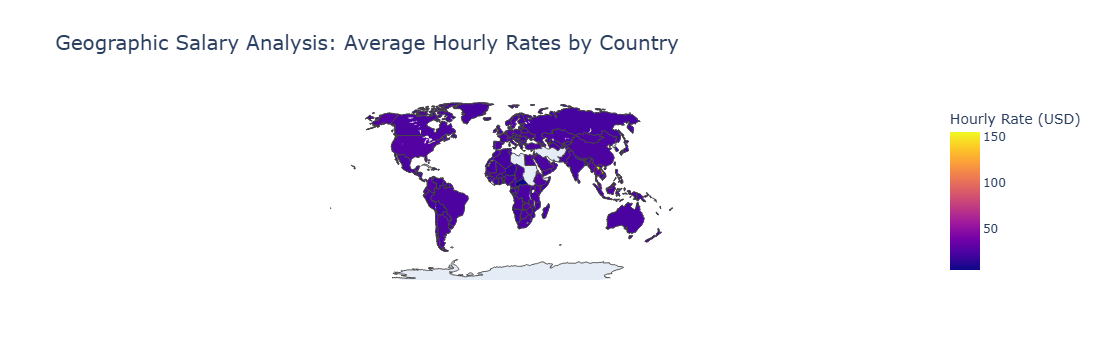

In [75]:
# Interactive Visualization with Plotly
import plotly.express as px

fig = px.choropleth(
    country_salary,
    locations="country",
    locationmode="country names",
    color="avg_hourly",  # Use the correct column name
    title="Geographic Salary Analysis: Average Hourly Rates by Country",
    color_continuous_scale="Plasma",
    labels={'avg_hourly': 'Avg Hourly Rate (USD)'}  # Update label to match the column name
)

fig.update_layout(
    geo=dict(showframe=False, projection_type="natural earth"),
    title_font_size=20,
    coloraxis_colorbar=dict(title="Hourly Rate (USD)")
)

fig.show()


<font size = '3'>

## Overall Interpretation:

The map provides a global overview of average hourly rates (in USD) across different countries. The color intensity corresponds to the hourly rate, with darker colors indicating higher rates.

## Specific Observations:

High Hourly Rates: Regions like North America, Western Europe, and Australia appear to have the highest average hourly rates, represented by darker shades of purple.

Lower Hourly Rates: Countries in Africa, South America, and parts of Asia are depicted with lighter shades, suggesting lower average hourly rates.

In [76]:
print(country_salary.head())

                    country  avg_hourly
0                      Laos  155.125000
1                   Eritrea   61.250000
2  Turks and Caicos Islands   46.625000
3                    Malawi   42.375000
4      Netherlands Antilles   35.416667


In [77]:
# Display the top and bottom 10 countries for hourly wages
print("Top 10 countries with highest wages:")
print(country_salary.head(10))

print("\nBottom 10 countries with lowest wages:")
print(country_salary.tail(10))

Top 10 countries with highest wages:
                    country  avg_hourly
0                      Laos  155.125000
1                   Eritrea   61.250000
2  Turks and Caicos Islands   46.625000
3                    Malawi   42.375000
4      Netherlands Antilles   35.416667
5             Liechtenstein   35.000000
6             French Guiana   34.000000
7                  Malaysia   31.661130
8                  Thailand   30.319061
9    British Virgin Islands   29.145833

Bottom 10 countries with lowest wages:
                                  country  avg_hourly
203                      French Polynesia   19.029412
204  United States Minor Outlying Islands   18.750000
205                            Guadeloupe   18.428571
206                              Holy See   17.500000
207                                 Aruba   17.263158
208                                 Niger   16.500000
209                     Brunei Darussalam   15.875000
210                                  Fiji   15.8333

## Task 5:  Personalized Job Recommendation System

In [85]:
# Combine important columns to create job description vectors
df['job_description'] = df['title'] + " " + df['country'] + " " + df['is_hourly'].astype(str)

In [86]:
# Fill missing values in 'job_description'
df['job_description'] = df['job_description'].fillna('')

In [87]:
# Use TfidfVectorizer to encode job descriptions
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
job_vectors = vectorizer.fit_transform(df['job_description'])

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244827 entries, 0 to 244827
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   title            244827 non-null  object             
 1   link             244827 non-null  object             
 2   published_date   244827 non-null  datetime64[ns, UTC]
 3   is_hourly        244827 non-null  bool               
 4   hourly_low       244827 non-null  float64            
 5   hourly_high      244827 non-null  float64            
 6   budget           244827 non-null  float64            
 7   country          244827 non-null  object             
 8   cleaned_title    244827 non-null  object             
 9   job_category     244827 non-null  object             
 10  YearMonth        244827 non-null  period[M]          
 11  avg_hourly       244827 non-null  float64            
 12  job_description  244827 non-null  object             
dtypes: b

In [89]:
# Save the model
with open("tfidf_model.pkl", "wb") as file:
    pickle.dump(vectorizer, file)

In [91]:
# Add dummy user profile for demonstration
user_profile = {
    'preferred_title': 'Data Scientist',
    'preferred_country': 'United States',
    'preferred_hourly': True
}

In [92]:
# Create a dummy user vector based on preferences
user_vector_input = (
    user_profile['preferred_title']
    + " " + user_profile['preferred_country']
    + " " + str(user_profile['preferred_hourly'])
)
user_vector = vectorizer.transform([user_vector_input])

In [93]:
# Computing cosine similarity between the user and job postings
similarity_scores = cosine_similarity(user_vector, job_vectors).flatten()

In [94]:
# Add similarity scores to the dataframe
df['similarity_score'] = similarity_scores

In [95]:
# Retrieve the top 10 recommended jobs for the user
top_recommendations = df.sort_values(by='similarity_score', ascending=False).head(10)
print("Top 10 Job Recommendations:")
print(top_recommendations[['title', 'country', 'similarity_score']])

Top 10 Job Recommendations:
                 title         country  similarity_score
236871  Data Scientist   United States          1.000000
52859   Data Scientist   United States          1.000000
99592   Data Scientist   United States          1.000000
20017   Data Scientist   United States          1.000000
217927  Data Scientist   United States          1.000000
192080  Data Scientist   United States          1.000000
44791   Data Scientist   United States          0.969423
14460   Data Scientist   United States          0.969423
174846  Data Scientist   United States          0.969423
101541  Data Scientist  United Kingdom          0.919806


In [97]:
df.to_csv('job_posting.csv',index=False)

## Task 7: Remote Work Landscape Analysis

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244827 entries, 0 to 244827
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   title             244827 non-null  object             
 1   link              244827 non-null  object             
 2   published_date    244827 non-null  datetime64[ns, UTC]
 3   is_hourly         244827 non-null  bool               
 4   hourly_low        244827 non-null  float64            
 5   hourly_high       244827 non-null  float64            
 6   budget            244827 non-null  float64            
 7   country           244827 non-null  object             
 8   cleaned_title     244827 non-null  object             
 9   job_category      244827 non-null  object             
 10  YearMonth         244827 non-null  period[M]          
 11  avg_hourly        244827 non-null  float64            
 12  job_description   244827 non-null  object        

In [99]:
# Identify Remote Jobs
df['is_remote'] = df['job_description'].str.contains(
    'remote|work from home|telecommute|online', case=False, na=False
)

In [100]:
# Compute Monthly Trends for Remote Jobs
df['YearMonth'] = df['published_date'].dt.to_period('M')  # Extract Year-Month
monthly_remote_trends = df.groupby('YearMonth')['is_remote'].mean() * 100

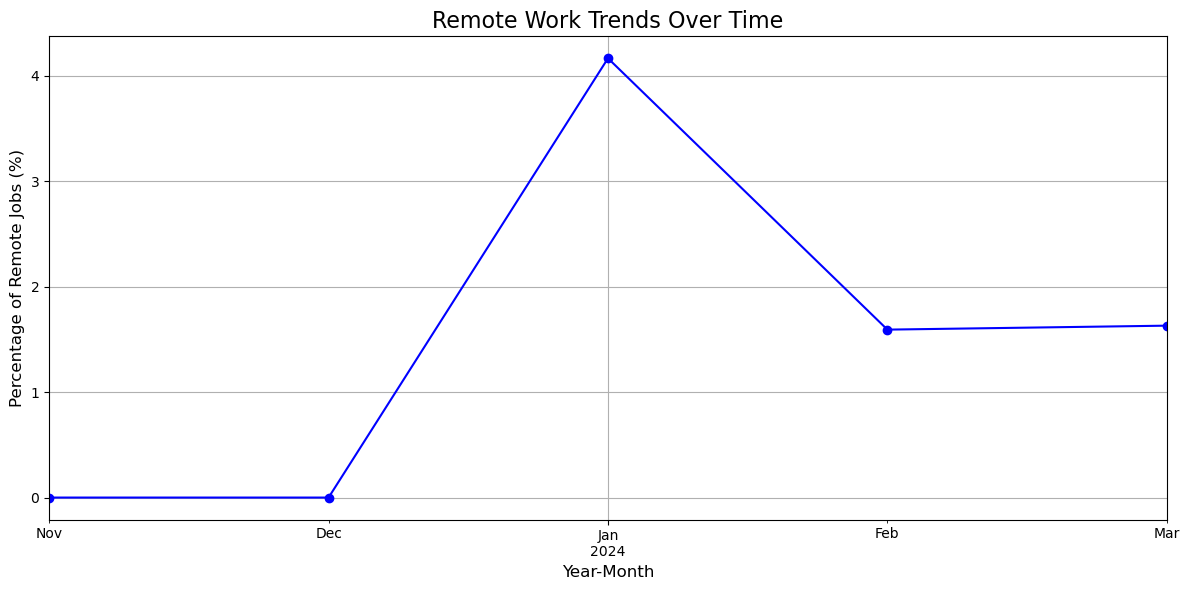

In [101]:
# Visualize Remote Work Trends Over Time
plt.figure(figsize=(12, 6))
monthly_remote_trends.plot(kind='line', marker='o', color='blue')
plt.title("Remote Work Trends Over Time", fontsize=16)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Percentage of Remote Jobs (%)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("remote_work_trends.png")
plt.show()

<font size = '3'>

## Overall Interpretation:

The graph illustrates the relative demand for different job roles over a period spanning from December 2023 to March 2024. The demand for all roles appears to be very low until around February 1st, 2024, when there is a sharp increase. The demand for all roles remains high until the end of the observed period.

## Possible Interpretations:

"Other" Role: The high demand for this category could be due to various factors such as emerging job roles, niche fields, or a broader definition that encompasses multiple professions.

Software Development: The consistent demand for software developers aligns with the ongoing technological advancements and the increasing reliance on software in various sectors.

Design, Content Writer, and Marketing: The growing importance of visual communication, digital marketing, and content creation across industries likely contributes to the increased demand for professionals in these areas.

In [105]:
# Forecast Future Trends

# Prepare data for regression
monthly_remote_trends_df = monthly_remote_trends.reset_index()
monthly_remote_trends_df['YearMonth_num'] = monthly_remote_trends_df['YearMonth'].apply(
    lambda x: x.to_timestamp().toordinal()
)
X = monthly_remote_trends_df[['YearMonth_num']]
y = monthly_remote_trends_df['is_remote']

In [106]:
# Train the regression model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [107]:
# Predict for the next 12 months
last_date = df['published_date'].max()
future_dates = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(), periods=12, freq='M'
)
future_dates_ordinal = future_dates.map(lambda x: x.toordinal()).values.reshape(-1, 1)
future_predictions = model.predict(future_dates_ordinal)

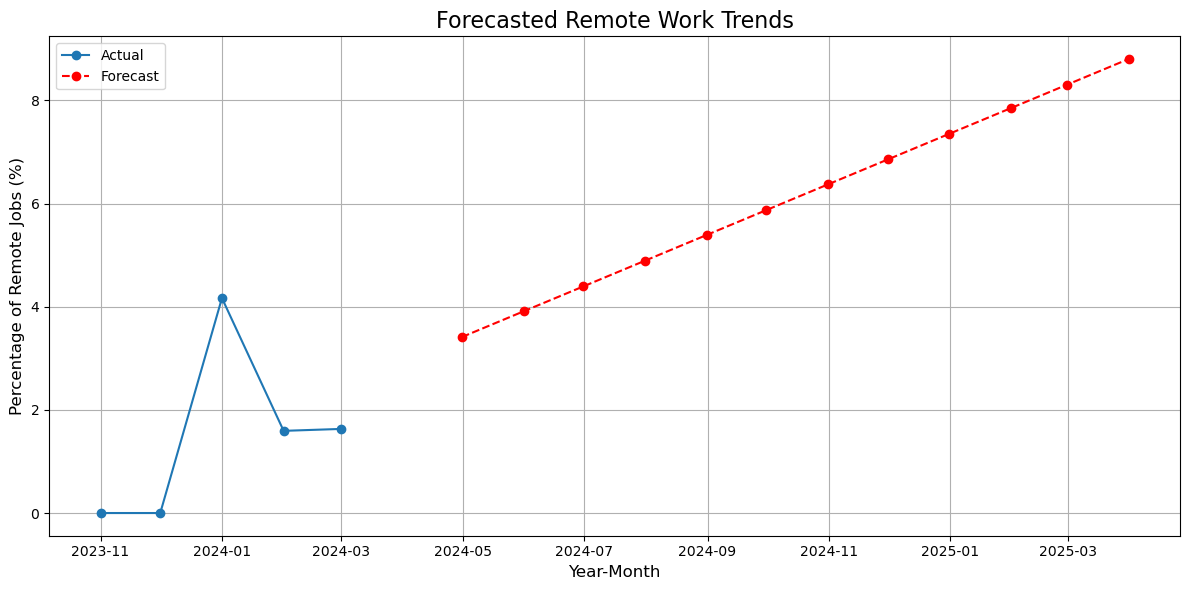

In [108]:
# Plot historical and forecasted trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_remote_trends.index.to_timestamp(), monthly_remote_trends, marker='o', label="Actual")
plt.plot(future_dates, future_predictions, linestyle='--', marker='o', color='red', label="Forecast")
plt.title("Forecasted Remote Work Trends", fontsize=16)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Percentage of Remote Jobs (%)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("forecasted_remote_work_trends.png")
plt.show()

<font size ='3'>

## Overall Interpretation:

The graph presents both actual and forecasted trends in the percentage of remote jobs over time, spanning from November 2023 to March 2025. The actual data shows a sharp increase in remote work followed by a decline, while the forecast predicts a continued and steady rise in remote work percentages.

## Specific Observations:

Actual Data:

There's a significant spike in the percentage of remote jobs between November 2023 and January 2024.
This is followed by a sharp decline in the percentage of remote jobs from January 2024 to February 2024.
The percentage remains relatively stable from February 2024 onwards.

Forecast:

The forecast predicts a continuous and steady increase in the percentage of remote jobs from March 2024 onwards.
The projected increase is more gradual compared to the initial spike in the actual data.

In [109]:
# Step 5: Summarize Insights
remote_rate = df['is_remote'].mean() * 100
print(f"Overall Remote Work Rate: {remote_rate:.2f}%")

recent_trends = monthly_remote_trends.tail(12)
forecasted_trends = dict(zip(future_dates.strftime('%Y-%m'), future_predictions))

print("\nRecent Monthly Trends:")
print(recent_trends)

print("\nForecasted Trends:")
for date, prediction in forecasted_trends.items():
    print(f"{date}: {prediction:.2f}%")

Overall Remote Work Rate: 1.62%

Recent Monthly Trends:
YearMonth
2023-11    0.000000
2023-12    0.000000
2024-01    4.166667
2024-02    1.592957
2024-03    1.630564
Freq: M, Name: is_remote, dtype: float64

Forecasted Trends:
2024-04: 3.41%
2024-05: 3.91%
2024-06: 4.39%
2024-07: 4.89%
2024-08: 5.39%
2024-09: 5.87%
2024-10: 6.37%
2024-11: 6.85%
2024-12: 7.35%
2025-01: 7.85%
2025-02: 8.30%
2025-03: 8.80%


## Trends by Job Category

In [112]:
# Remote job trends per category
category_remote_trends = (
    df.groupby(['job_category', 'YearMonth'])['is_remote']
    .mean()
    .unstack(level=0)
)

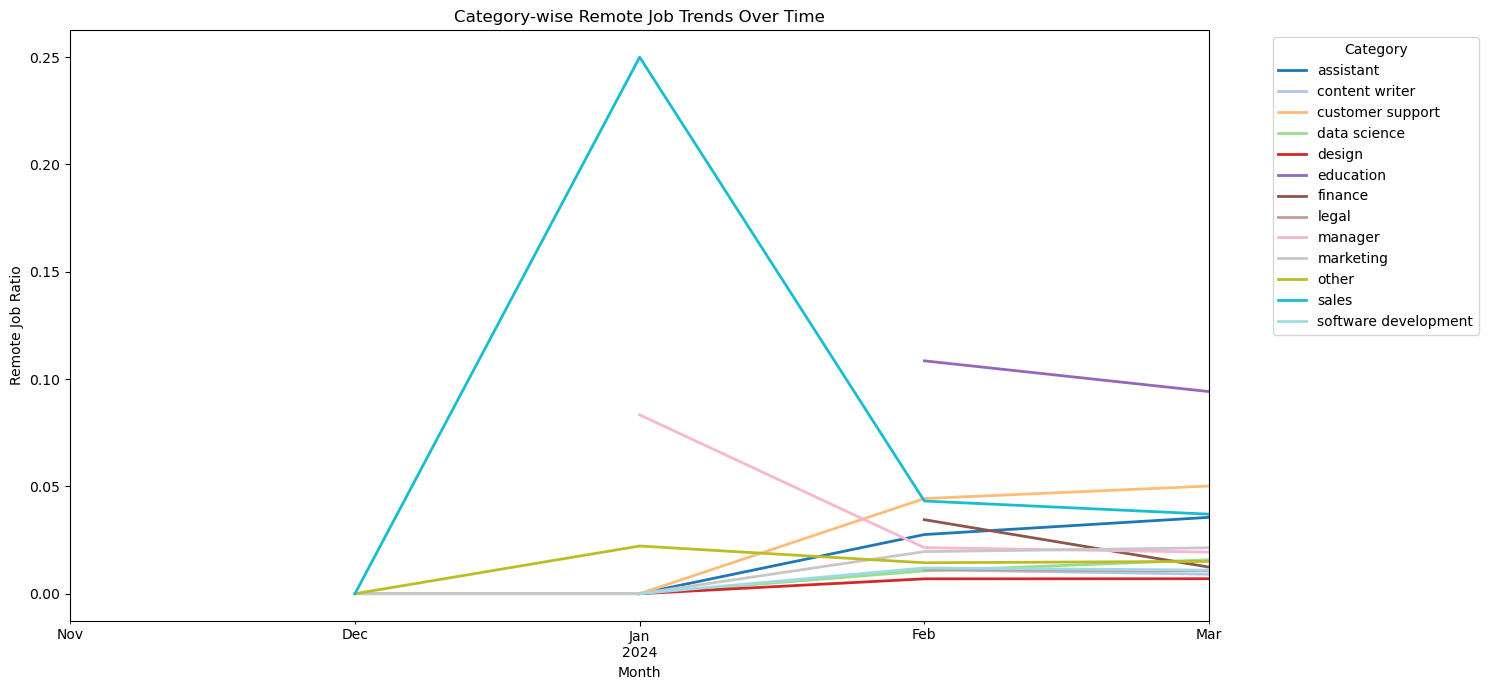

In [113]:
# Visualization of trends
plt.figure(figsize=(15, 7))
category_remote_trends.plot(ax=plt.gca(), cmap="tab20", linewidth=2)
plt.title('Category-wise Remote Job Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Remote Job Ratio')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("category_remote_trends.png")
plt.show()

<FONT SIZE = '3'>

## INTERPRETATION

The graph provides a snapshot of remote job trends across different categories. While the trends vary, the overall picture suggests a growing adoption of remote work, with some categories experiencing a more pronounced shift compared to others.

## Task 8: Predicting Future Workforce Trends

In [115]:
df['YearMonth'].value_counts()

YearMonth
2024-03    142834
2024-02    101886
2024-01        96
2023-12        10
2023-11         1
Freq: M, Name: count, dtype: int64

In [116]:
df.head()

title  \
0  Experienced Media Buyer For Solar Pannel and R...   
1                               Full Stack Developer   
2                                    SMMA Bubble App   
3             Talent Hunter Specialized in Marketing   
4                                      Data Engineer   

                                                link  \
0  https://www.upwork.com/jobs/Experienced-Media-...   
1  https://www.upwork.com/jobs/Full-Stack-Develop...   
2  https://www.upwork.com/jobs/SMMA-Bubble-App_%7...   
3  https://www.upwork.com/jobs/Talent-Hunter-Spec...   
4  https://www.upwork.com/jobs/Data-Engineer_%7E0...   

             published_date  is_hourly  hourly_low  hourly_high  budget  \
0 2024-02-17 09:09:54+00:00      False        15.0         30.0   500.0   
1 2024-02-17 09:09:17+00:00      False        15.0         30.0  1100.0   
2 2024-02-17 09:08:46+00:00       True        10.0         30.0    20.0   
3 2024-02-17 09:08:08+00:00       True        15.0         30.0    22.5   
4 2024-02-17 09:07:42+00:00      False        15.0         30.0   650.0   

         country                                      cleaned_title  \
0        Unknown  experienced media buyer solar pannel roofing i...   
1  United States                               full stack developer   
2  United States                                    smma bubble app   
3  United States                talent hunter specialized marketing   
4          India                                      data engineer   

           job_category YearMonth  avg_hourly  \
0                 other   2024-02        22.5   
1  software development   2024-02        22.5   
2                 other   2024-02        20.0   
3             marketing   2024-02        22.5   
4  software development   2024-02        22.5   

                                     job_description  similarity_score  \
0  Experienced Media Buyer For Solar Pannel and R...          0.000000   
1           Full Stack Developer United States False          0.088332   
2                 SMMA Bubble App United States True          0.070677   
3  Talent Hunter Specialized in Marketing United ...          0.056631   
4                          Data Engineer India False          0.258671   

   is_remote  
0      False  
1      False  
2      False  
3      False  
4      False

In [119]:
# Aggregate data by YearMonth
monthly_data = df.groupby('YearMonth').agg({
    'is_remote': 'sum',  # Number of remote jobs
    'budget': 'mean',    # Average budget
    'avg_hourly': 'mean',  # Average hourly rate
    'title': 'count'  # Total number of jobs
}).reset_index()
monthly_data.rename(columns={'title': 'total_jobs'}, inplace=True)

In [120]:
monthly_data

YearMonth  is_remote      budget  avg_hourly  total_jobs
0   2023-11          0   37.500000   37.500000           1
1   2023-12          0   96.050000   25.550000          10
2   2024-01          4  124.786458   22.630208          96
3   2024-02       1623  394.518452   25.586572      101886
4   2024-03       2329  408.635826   25.275792      142834

In [126]:
# Convert YearMonth to datetime for modeling
monthly_data['YearMonth'] = monthly_data['YearMonth'].dt.to_timestamp()
monthly_data.set_index('YearMonth', inplace=True)

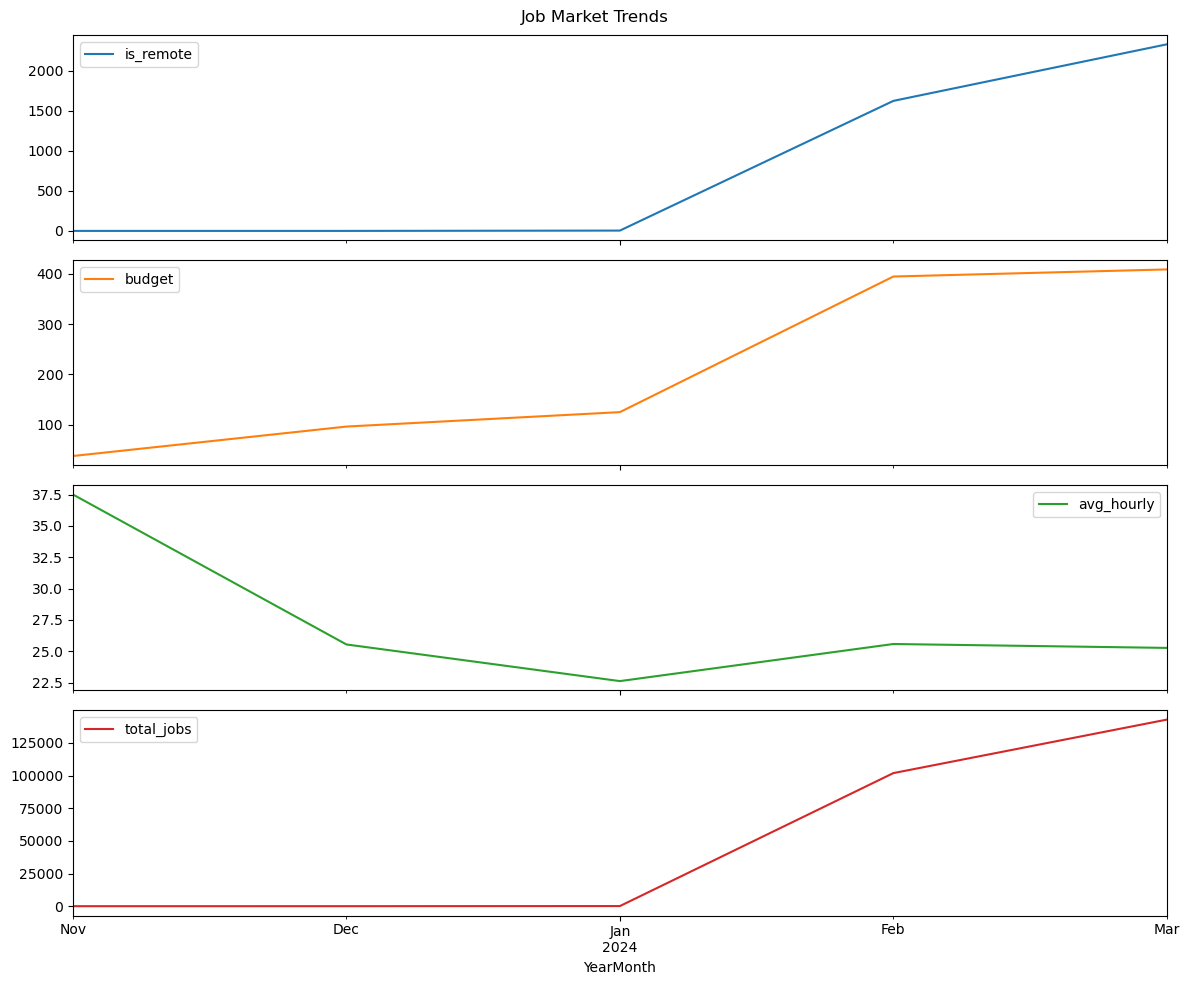

In [127]:
# Plot the trends
monthly_data.plot(subplots=True, figsize=(12, 10), title="Job Market Trends")
plt.tight_layout()
plt.show()

In [128]:
# ARIMA model for total jobs
arima_model = ARIMA(monthly_data['total_jobs'], order=(1, 1, 1))
arima_result = arima_model.fit()

C:\Users\Sujana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\Sujana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\Sujana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [129]:
# Predict future values
future_steps = 12  # Predict for the next year
forecast_arima = arima_result.forecast(steps=future_steps)
forecast_arima.index = pd.date_range(start=monthly_data.index[-1], periods=future_steps + 1, freq='M')[1:]

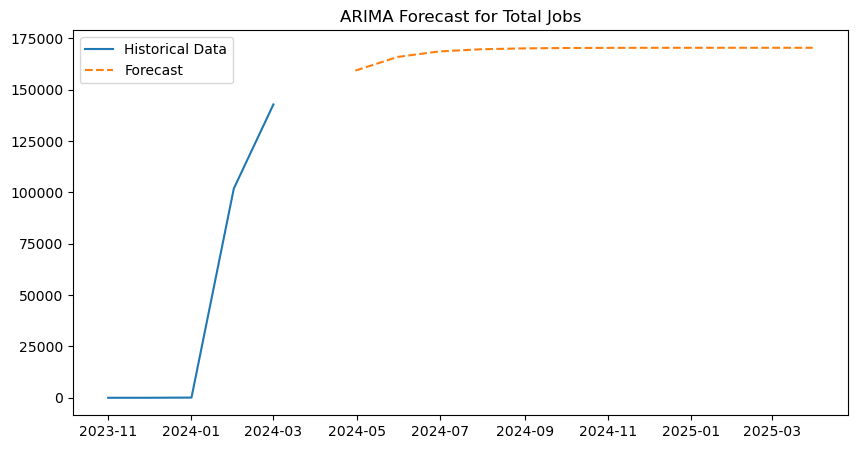

In [130]:
# Plot forecast
plt.figure(figsize=(10, 5))
plt.plot(monthly_data['total_jobs'], label='Historical Data')
plt.plot(forecast_arima, label='Forecast', linestyle='--')
plt.title('ARIMA Forecast for Total Jobs')
plt.legend()
plt.show()

<font size = '3'>

## INTERPRETATION

Historical Data: 
The historical data shows a relatively low number of total jobs until January 2024. There's a significant jump in February 2024, followed by a further increase in March 2024. This indicates a period of rapid job growth in the recent past.

Forecast:
The forecast (orange dashed line) suggests a major increase in total jobs starting from April 2024.
The growth rate appears to slow down slightly after the initial surge, but the overall trend remains upward, indicating continued job growth through March 2025.

In [131]:
# Prepare data for Prophet
prophet_data = monthly_data.reset_index()[['YearMonth', 'is_remote']]
prophet_data.columns = ['ds', 'y']

In [136]:
from prophet import Prophet

# Initialize and fit Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

23:02:26 - cmdstanpy - INFO - Chain [1] start processing
23:02:27 - cmdstanpy - INFO - Chain [1] done processing


In [137]:
# Create future dataframe
future_dates = prophet_model.make_future_dataframe(periods=future_steps, freq='M')
forecast_prophet = prophet_model.predict(future_dates)

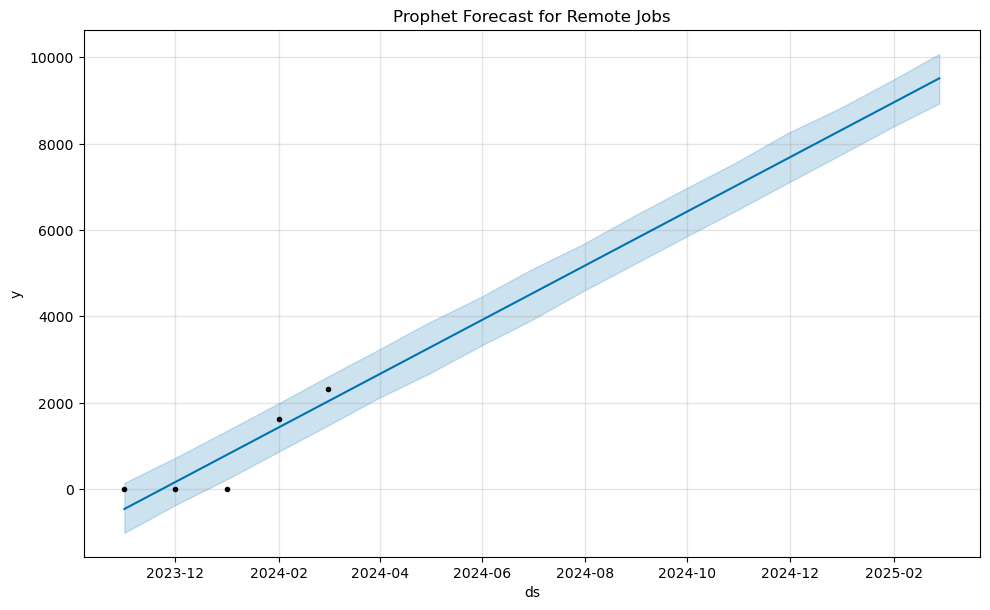

In [138]:
# Plot Prophet forecast
fig = prophet_model.plot(forecast_prophet)
plt.title('Prophet Forecast for Remote Jobs')
plt.show()

<FONT SIZE - '3'>

## Overall Interpretation:

This graph shows a forecast of remote job postings using the Prophet model, a time series forecasting tool developed by Facebook. The key takeaway is that the model predicts a continued upward trend in remote job postings, with both a clear upward trajectory (represented by the dark blue line) and a range of possible future values (the light blue shaded area).

## Specific Observations:

Historical Data (Black Dots): These points represent the actual observed number of remote job postings. They provide the basis for the model's forecast. The data shows a general upward trend already, which the model picks up on.

Forecast Line (Dark Blue): This line represents the model's most likely prediction for the number of remote job postings in the future. It shows a consistent and fairly linear increase through to early 2025.

Confidence Interval (Light Blue Shaded Area): This area represents the range of possible values for the forecast. It indicates that while the dark blue line is the most likely scenario, the actual number of remote job postings could fall within this range. The further out into the future, the wider the range, reflecting increased uncertainty.

ds (X-axis): This represents the date (likely daily or weekly, though the exact interval isn't specified).

Y-axis: This represents the number of remote job postings.

## Possible Interpretations:

Continued Growth of Remote Work: The forecast strongly suggests that the trend of increasing remote job opportunities will continue. This could be driven by factors like technological advancements, changing work preferences, and companies embracing remote work models for various benefits.
Relatively Consistent Growth: The linear nature of the forecast suggests a steady and consistent increase, rather than explosive growth or decline.
Uncertainty Increases with Time: The widening confidence interval is a natural feature of forecasting. It implies that the model is more certain about near-term predictions and less certain about long-term ones.

## EVALUATING THE ARIMA MODEL

In [139]:
# Evaluate ARIMA model
y_true = monthly_data['total_jobs'][-5:]  # Actual values from the last year
y_pred_arima = arima_result.predict(start=len(monthly_data) - 5, end=len(monthly_data) - 1)

In [140]:
rmse_arima = np.sqrt(mean_squared_error(y_true, y_pred_arima))
mape_arima = mean_absolute_percentage_error(y_true, y_pred_arima)

print(f"RMSE of ARIMA: {rmse_arima:.2f}")
print(f"MAPE OF ARIMA: {mape_arima:.2%}")

RMSE of ARIMA: 45506.40
MAPE OF ARIMA: 74.34%
